# Data Preparation Workflow

This notebook demonstrates the data preparation workflow for the Snow Drought Index package. It covers loading data, preprocessing, station extraction and filtering, and data availability assessment.

# Data Preparation Workflow

This notebook demonstrates the data preparation workflow for the Snow Drought Index package. It covers loading data, preprocessing, station extraction and filtering, and data availability assessment.

# Install missing packages

#%pip install bottleneck

#%pip install git+https://github.com/Nadiesenali/snowdroughtindex-main   # Install snowdroughtindex from the local source directory

#%pip install --force-reinstall git+https://github.com/Nadiesenali/snowdroughtindex-main

# Import required packages

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import Point
import sys
from sklearn.metrics import mean_squared_error
import datetime
from pathlib import Path
from scipy.interpolate import interp1d
import random

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))

# Import snowdroughtindex package
from snowdroughtindex.core import data_preparation
from snowdroughtindex.core.gap_filling_notebook import *

First, we'll load the SWE data and other required datasets.

In [2]:
# Define data paths
canswe_path = project_root / 'data' / 'input_data' /'CanSWE'/'CanSWE-CanEEN_1928-2024_v7.nc'
CaSR_path = project_root / 'data' / 'output_data' /'casr_data'/'bow_combined_data.csv'
basin_path = project_root / 'data' / 'input_data' /'Elevation'/'Bow_elevation_combined.shp'
output_data = project_root / 'data' /'output_data'/'FROSTBYTE//'
output_plots = project_root / 'data' /'output_plots'/'FROSTBYTE//'

In [3]:
# Load data using the implemented functions
canswe = data_preparation.load_swe_data(canswe_path)
casr_data = pd.read_csv(CaSR_path)
bow_basin = data_preparation.load_basin_data(basin_path)

# Extract CanSWE data for stations within the Bow basin

In [4]:
# Get station locations from canswe
stations_df = pd.DataFrame({
	'station_id': canswe['station_id'].values,
	'lat': canswe['lat'].values,
	'lon': canswe['lon'].values
})

# Create Point geometries for each station
stations_gdf = gpd.GeoDataFrame(
	stations_df,
	geometry=gpd.points_from_xy(stations_df['lon'], stations_df['lat']),
	crs=bow_basin.crs
)

# Find stations within any of the Bow basin polygons
stations_in_basin = stations_gdf[stations_gdf.within(bow_basin.unary_union)]

# Select these stations from canswe
bow_canswe = canswe.sel(station_id=stations_in_basin['station_id'].values)

# Convert to DataFrame
#bow_canswe_df = bow_canswe.to_dataframe().reset_index()

# Save the extracted data to a nc file
#bow_canswe.to_netcdf(output_data + 'bow_canswe.nc')

C:\Users\askha\AppData\Local\Temp\ipykernel_41868\4270623507.py:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  stations_in_basin = stations_gdf[stations_gdf.within(bow_basin.unary_union)]


# Extract CaSRv3.1 SWE data within the Bow basin

In [5]:
# CaSR dataframe
casr_df = pd.DataFrame(casr_data)

# kee SWE, 'date', 'Grid_id', 'Elevation_category
casr_df = casr_df[['time', 'Grid_id','lat', 'lon', 'Elevation_Category','SWE']]

display(casr_df.head())
# convert to geodataframe
casr_gdf = gpd.GeoDataFrame(
    casr_df,
    geometry=gpd.points_from_xy(casr_df['lon'], casr_df['lat']),
    crs=bow_basin.crs
)
display(casr_gdf.head())

,time,Grid_id,lat,lon,Elevation_Category,SWE
0,1980-10-10,1,51.334590,-116.13797,2000_2500m,0.878418
1,1982-07-19,1,51.334590,-116.13797,2000_2500m,0.515625
2,1983-10-12,2,51.419113,-116.18750,2000_2500m,6.875000
3,1980-12-11,2,51.419113,-116.18750,2000_2500m,118.125000
4,1981-07-21,2,51.419113,-116.18750,2000_2500m,0.000000


,time,Grid_id,lat,lon,Elevation_Category,SWE,geometry
0,1980-10-10,1,51.334590,-116.13797,2000_2500m,0.878418,POINT (-116.13797 51.33459)
1,1982-07-19,1,51.334590,-116.13797,2000_2500m,0.515625,POINT (-116.13797 51.33459)
2,1983-10-12,2,51.419113,-116.18750,2000_2500m,6.875000,POINT (-116.1875 51.41911)
3,1980-12-11,2,51.419113,-116.18750,2000_2500m,118.125000,POINT (-116.1875 51.41911)
4,1981-07-21,2,51.419113,-116.18750,2000_2500m,0.000000,POINT (-116.1875 51.41911)


C:\Users\askha\AppData\Local\Temp\ipykernel_41868\2356830503.py:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(str(output_plots / 'bow_basin_by_elev_class.png'), dpi=300)
c:\Users\askha\github\snowdroughtindex-main\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


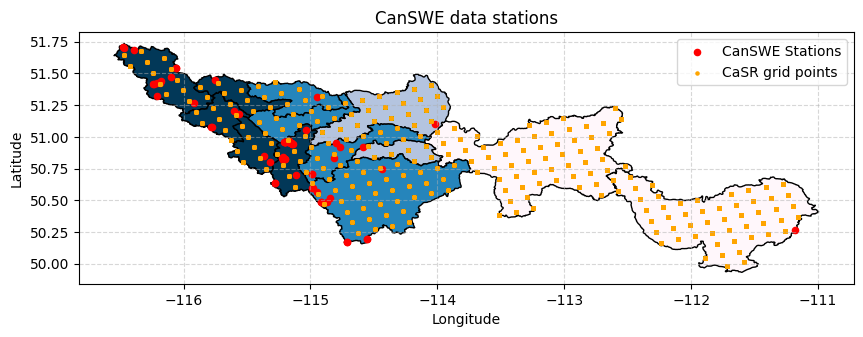

In [6]:
# Plot Bow basin polygons colored by elevation category
fig, ax = plt.subplots(figsize=(10, 10))

# Create elevation class column based on 'mean' elevation
bins = [500, 1000, 1500, 2000, 2500]
labels = ['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m']
bow_basin['elev_class'] = pd.cut(bow_basin['mean'], bins=bins, labels=labels, include_lowest=True, right=False)

# Ensure elev_class is a categorical type with desired order
bow_basin['elev_class'] = pd.Categorical(
    bow_basin['elev_class'],
    categories=labels,
    ordered=True
)

bow_basin.plot(ax=ax, column='elev_class', cmap='PuBu', legend=True, edgecolor='black')
# Add station points
stations_in_basin.plot(ax=ax, color='red', markersize=20, label='CanSWE Stations')
casr_gdf.plot(ax=ax, color='orange', markersize=5, label='CaSR grid points')
ax.set_title('CanSWE data stations')
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.savefig(str(output_plots / 'bow_basin_by_elev_class.png'), dpi=300)
plt.show()

## 1. FROSTBYTE gap filling

FROSTBYTE workflow  (In the original workflow, SCDNA precipitation data were also used to increase the data availability. However, here I'm only using CanSWE data because I couldn't find compatible precipitation dataset for the time period 1980-2024)

In [7]:
# Set user-specified variables
flag_buffer_default, buffer_km_default = 0, 0 # buffer flag (0: no buffer around test basin, 1: buffer of value buffer_default around test basin) and buffer default value in km to be applied if flag = 1
month_start_water_year_default, day_start_water_year_default = 10, 1  # water year start
month_end_water_year_default, day_end_water_year_default = 9, 30  # water year end
min_obs_corr_default = 3 # the minimum number of overlapping observations required to calculate the correlation between 2 stations
min_obs_cdf_default = 10 # the minimum number of observations required to calculate a station's cdf
min_corr_default = 0.6 # the minimum correlation value required for donor stations to be selected
window_days_default = 7 # the number of days used on either side of the infilling date for gap filling calculations
min_obs_KGE_default = 3 # the minimum number of observations required to calculate the KGE''
max_gap_days_default = 15  # max. number of days for gaps allowed in the daily SWE data for the linear interpolation
artificial_gap_perc_default = 100 # the percentage of observations to remove during the artificial gap filling for each station & month's first day
iterations_default = 1 # the number of times we repeat the artificial gap filling
artificial_gap_filling_flag = 0 # indicates whether artificial gap filling is performed (1) or not (0)
artificial_gap_filling_basins = ['all'] # a list of the basin(s) to run the gap filling for. To include all basins simply write 'all'

In [8]:
# open bow_canswe.csv file
bow_canswe = pd.read_csv(output_data / 'bow_canswe.csv')

C:\Users\askha\AppData\Local\Temp\ipykernel_41868\3240116601.py:2: DtypeWarning: Columns (7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  bow_canswe = pd.read_csv(output_data / 'bow_canswe.csv')


In [9]:
# Re-organize the dataset as needed

# Restrict bow_canswe to 1980-01-01 through 2024-07-31
bow_canswe['time'] = pd.to_datetime(bow_canswe['time'])
SWE_stations_df = bow_canswe[(bow_canswe['time'] >= '1980-01-01') & (bow_canswe['time'] <= '2023-07-31')]

# If you want to convert this DataFrame to an xarray Dataset similar to the original code:
SWE_stations_ds = SWE_stations_df.set_index(['station_id', 'time']).to_xarray()

display(SWE_stations_ds)

<xarray.Dataset> Size: 169MB
Dimensions:           (station_id: 78, time: 15918)
Coordinates:
  * station_id        (station_id) object 624B 'ALE-05BA801' ... 'UU-MC-VVFrst'
  * time              (time) datetime64[ns] 127kB 1980-01-01 ... 2023-07-31
Data variables: (12/17)
    lat               (station_id, time) float64 10MB 51.42 51.42 ... 50.97
    lon               (station_id, time) float64 10MB -116.2 -116.2 ... -115.2
    elevation         (station_id, time) float64 10MB 1.58e+03 ... 1.939e+03
    source            (station_id, time) object 10MB 'Alberta Environment' .....
    station_name      (station_id, time) object 10MB 'BOW RIVER' ... 'VistaVi...
    station_name_sec  (station_id, time) object 10MB 'BOW RIVER' ... nan
    ...                ...
    snd               (station_id, time) float64 10MB nan nan nan ... nan nan
    den               (station_id, time) float64 10MB nan nan nan ... nan nan
    data_flag_snw     (station_id, time) object 10MB "b''" "b''" ... "b''" "b''"
    data_flag_snd     (station_id, time) object 10MB "b''" "b''" ... "b''" "b''"
    qc_flag_snw       (station_id, time) object 10MB "b''" "b''" ... "b''" "b''"
    qc_flag_snd       (station_id, time) object 10MB "b''" "b''" ... "b''" "b''"

In [10]:
# dataframe of the SWE stations
bow_canswe_df = SWE_stations_ds.to_dataframe().reset_index()

# Extract unique station coordinates
unique_stations = bow_canswe_df.reset_index().drop_duplicates(subset='station_id')[['station_id', 'lon', 'lat']]

# Convert SWE stations DataArray to GeoDataFrame for further analysis
data = {'station_id': unique_stations['station_id'].values, 
        'lon': unique_stations['lon'].values, 
        'lat': unique_stations['lat'].values} 
df = pd.DataFrame(data)
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
crs = "EPSG:4326"
SWE_stations_gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

display(SWE_stations_gdf)

,station_id,lon,lat,geometry
0,ALE-05BA801,-116.183690,51.423084,POINT (-116.18369 51.42308)
1,ALE-05BA802,-116.181274,51.437960,POINT (-116.18127 51.43796)
2,ALE-05BA806,-116.238270,51.416620,POINT (-116.23827 51.41662)
3,ALE-05BA808,-116.213310,51.424427,POINT (-116.21331 51.42443)
4,ALE-05BA810,-116.102745,51.474090,POINT (-116.10274 51.47409)
...,...,...,...,...
73,UU-MC-LvlFrst,-115.146805,50.946804,POINT (-115.1468 50.9468)
74,UU-MC-UpFrst,-115.175060,50.956860,POINT (-115.17506 50.95686)
75,UU-MC-UppClr,-115.175440,50.956570,POINT (-115.17544 50.95657)
76,UU-MC-VVClr,-115.172120,50.970898,POINT (-115.17212 50.9709)


In [11]:
# Convert test basin SWE data DataSet to Pandas DataFrame for further analysis
SWE_testbasin_df = SWE_stations_ds.to_dataframe().drop(columns=['lon','lat','station_name']).unstack()['snw'].T

# Remove time from dates
SWE_testbasin_df['date'] = SWE_testbasin_df.index.normalize()
SWE_testbasin_df = SWE_testbasin_df.set_index('date')

# Drop the dates with no data at all across all stations
SWE_testbasin_df = SWE_testbasin_df.dropna(axis=0, how='all')

# Choose data for the period of interest 1980 - 2024
SWE_testbasin_df = SWE_testbasin_df.loc['1980-01-01':'2023-07-31']

display(SWE_testbasin_df)

station_id,ALE-05BA801,ALE-05BA802,ALE-05BA806,ALE-05BA808,ALE-05BA810,ALE-05BA811,ALE-05BA812,ALE-05BA813,ALE-05BA814,ALE-05BB803,...,UU-MC-FisRdgTp,UU-MC-FisS,UU-MC-FisSFFrst,UU-MC-FisUpS,UU-MC-Hay,UU-MC-LvlFrst,UU-MC-UpFrst,UU-MC-UppClr,UU-MC-VVClr,UU-MC-VVFrst
date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,371.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


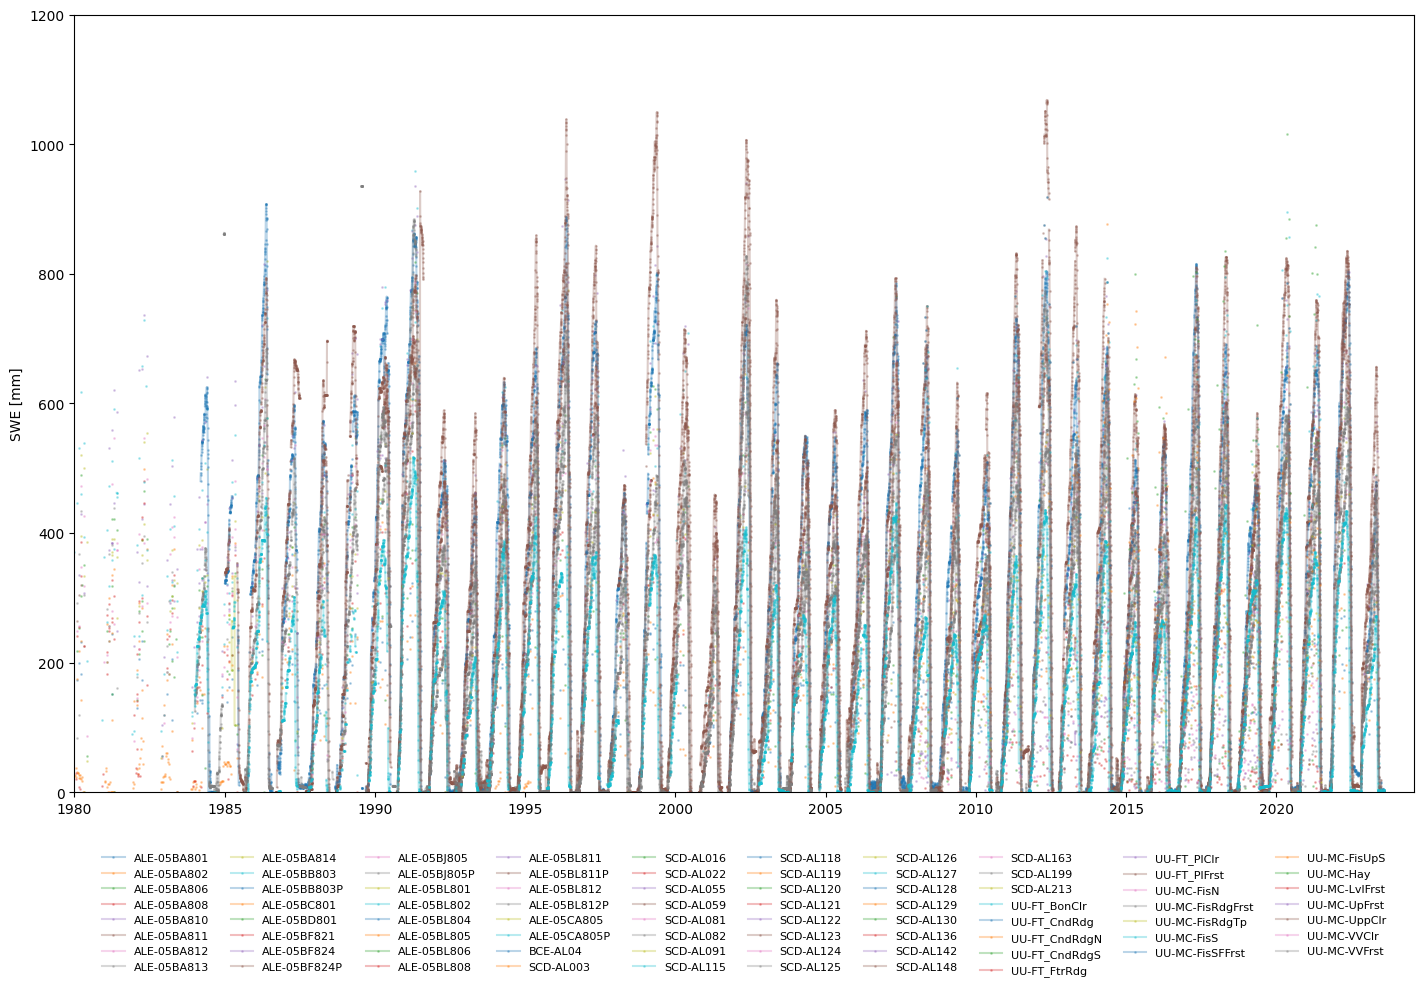

In [12]:
# Plot timeseries of SWE station observations in the test basin
fig = plt.figure(figsize=(15,10))

for s in SWE_stations_ds.station_id.values:
    SWE_stations_ds.snw.sel(station_id = s).plot(marker='o', alpha=.3, markersize=1, label=s)

plt.title('')
plt.ylabel('SWE [mm]')
plt.xlabel('')
plt.xlim(pd.to_datetime('1980-01-01'), pd.to_datetime('2024-07-31'))
plt.ylim(0, 1200)
# Place legend at the bottom with 5 columns per line
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=10, fontsize=8, frameon=False)
plt.tight_layout();

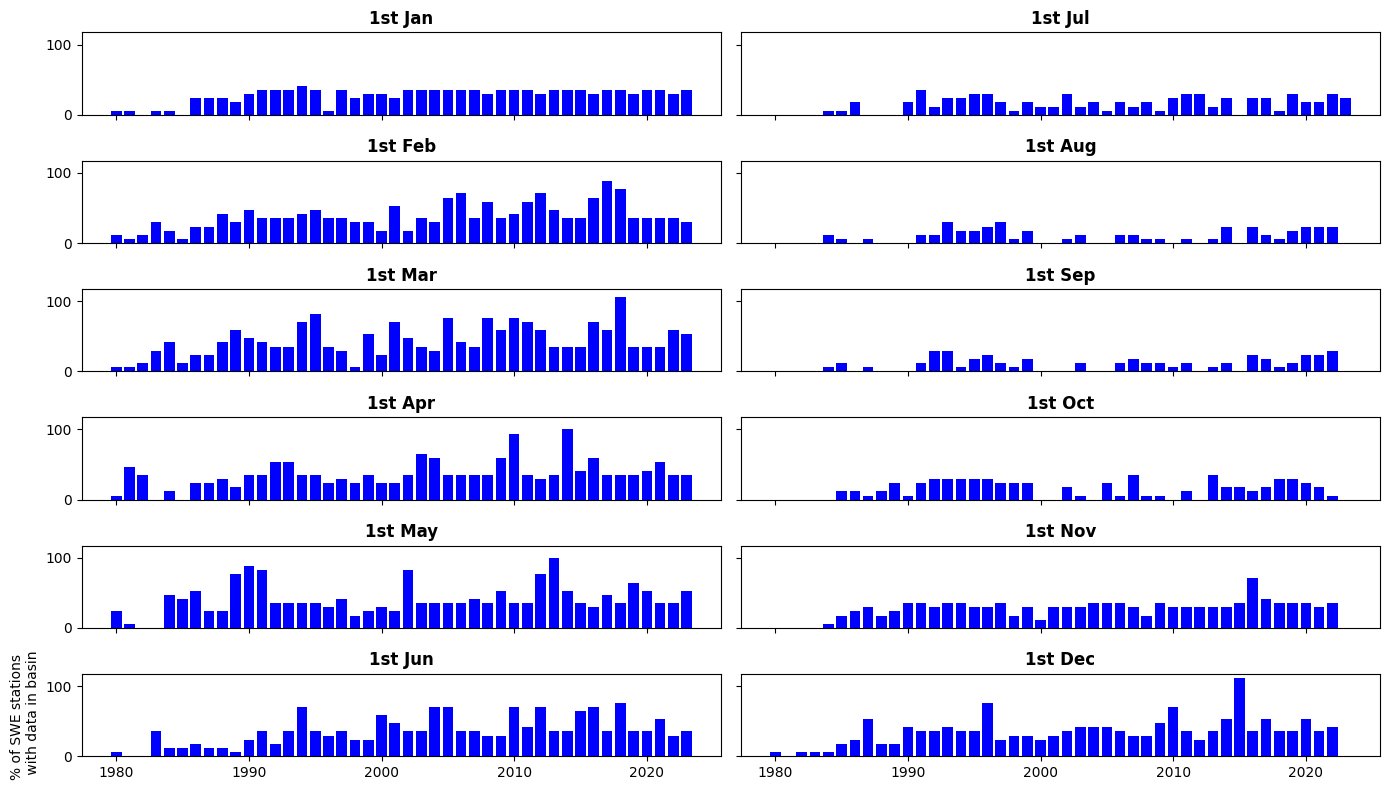

In [13]:
# Plot data availabity monthly plots

data_availability = data_availability_monthly_plots_1(SWE_stations_ds, SWE_stations_ds.snw, None, flag=0)

# Save the plot
data_availability.savefig(output_plots / 'data_availability_monthly_plots_1.png', dpi=300)

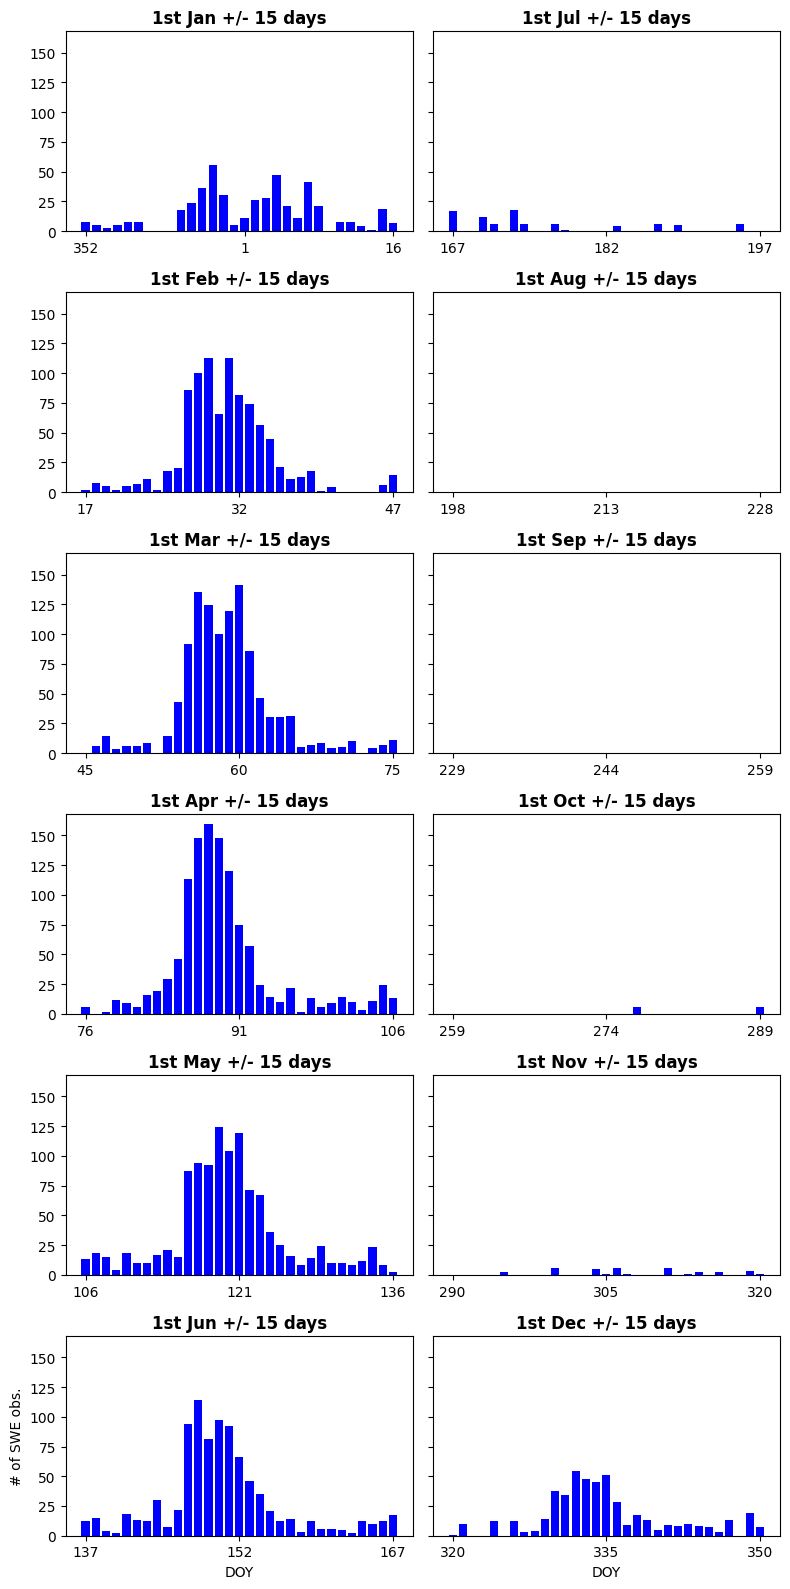

In [14]:
# Plot bar charts of the days with SWE observations around the first day of each month
fig = data_availability_monthly_plots_2(SWE_testbasin_df)

Connect CaSR SWE data to CanSWE data before linear interpolation 

In [15]:
# Load CaSRv3.1 data
casr_data = pd.read_csv(CaSR_path)
# Convert 'time' column to datetime
casr_data['time'] = pd.to_datetime(casr_data['time'])
# Create a DataFrame from the CaSR data
casr_df = pd.DataFrame(casr_data)

display(casr_df.head())

,Grid_id,time,lon,lat,SWE,Precipitation,Elevation_Category
0,1,1980-10-10,-116.13797,51.334590,0.878418,0.009879,2000_2500m
1,1,1982-07-19,-116.13797,51.334590,0.515625,2.765854,2000_2500m
2,2,1983-10-12,-116.18750,51.419113,6.875000,0.023846,2000_2500m
3,2,1980-12-11,-116.18750,51.419113,118.125000,4.578907,2000_2500m
4,2,1981-07-21,-116.18750,51.419113,0.000000,5.400473,2000_2500m


In [16]:
# rename Grid_id to station_id and keep SWE, 'time', 'station_id'
casr_df = casr_df[['time', 'Grid_id','SWE']]
casr_df.rename(columns={'Grid_id': 'station_id','time':'date'}, inplace=True)
display(casr_df.head())

,date,station_id,SWE
0,1980-10-10,1,0.878418
1,1982-07-19,1,0.515625
2,1983-10-12,2,6.875000
3,1980-12-11,2,118.125000
4,1981-07-21,2,0.000000


In [17]:
# Check column names to ensure 'date' exists
print(casr_df.columns)

# Pivot the CaSR DataFrame to have dates as index and station_id as columns
casr_df = casr_df.pivot(index='date', columns='station_id', values='SWE')

# Optionally, rename the columns to a simple format if needed
casr_df.columns = [f'SWE_{i+1}' for i in range(len(casr_df.columns))]

display(casr_df)

Index(['date', 'station_id', 'SWE'], dtype='object')


,SWE_1,SWE_2,SWE_3,SWE_4,SWE_5,SWE_6,SWE_7,SWE_8,SWE_9,SWE_10,...,SWE_248,SWE_249,SWE_250,SWE_251,SWE_252,SWE_253,SWE_254,SWE_255,SWE_256,SWE_257
date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,110.3750,129.0625,126.0000,95.18750,112.2500,76.7500,61.1875,71.25000,71.1875,64.250,...,32.062500,28.3125,37.000000,35.8125,30.625000,5.250000,5.437500,3.562500,3.8125,6.687500
1980-01-02,110.7500,129.3750,126.2500,95.50000,112.7500,77.3125,62.0000,71.75000,72.0000,65.000,...,34.000000,32.7500,39.250000,40.1250,34.937500,6.187500,6.375000,4.375000,4.5000,7.250000
1980-01-03,109.5625,127.8125,124.4375,93.87500,111.3750,76.3750,60.9375,71.75000,70.5625,64.250,...,36.687500,35.4375,41.937500,43.1250,37.687500,6.625000,7.125000,4.687500,4.7500,7.562500
1980-01-04,109.0625,127.5000,123.6875,93.12500,111.0625,76.0625,60.3750,71.68750,69.8125,63.750,...,38.312500,37.0625,43.500000,44.4375,39.250000,7.937500,8.375000,6.062500,6.6250,9.125000
1980-01-05,108.0625,126.0000,122.1875,91.56250,109.8750,75.1875,59.2500,71.12500,68.8125,63.000,...,39.437500,37.8125,44.750000,44.8750,39.812500,7.187500,7.750000,5.312500,5.7500,8.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,75.1250,85.7500,71.5000,61.37500,71.8750,58.7500,46.5000,71.50000,46.5000,55.250,...,0.125000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
2023-12-28,74.8750,85.6250,71.2500,61.12500,71.7500,58.8750,46.1250,71.75000,46.0000,55.000,...,0.128906,0.0000,0.000977,0.1250,0.000244,0.000488,0.000244,0.000244,0.0000,0.000488
2023-12-29,75.5000,86.3750,71.8750,61.75000,72.3750,59.6250,47.1250,72.75000,46.8750,56.250,...,0.125000,0.0000,0.125000,0.1250,0.000000,0.000488,0.000000,0.000000,0.0000,0.000000


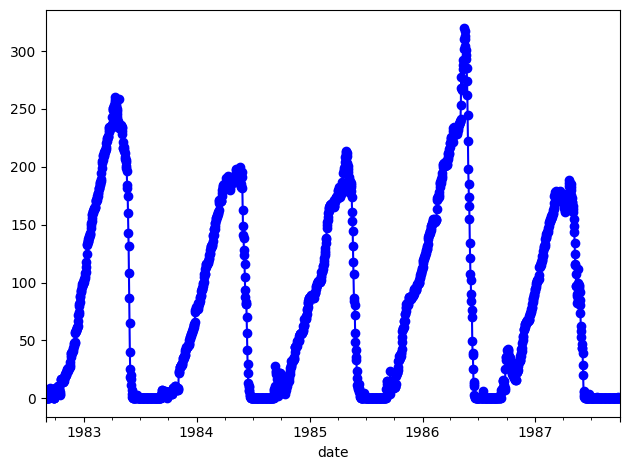

In [18]:
# Visual check
casr_df['SWE_5']['1982-09-01':'1987-10-02'].plot(marker='o', color='b')
plt.tight_layout();

In [19]:
SWE_stations_ds['time'] = pd.date_range(start='1980-01-01', periods=SWE_stations_ds.dims['time'], freq='D')

# Linear interpolation to fill in small data gaps
SWE_testbasin_interp_da = SWE_stations_ds.snw.interpolate_na(method='linear', dim='time', max_gap=datetime.timedelta(days=max_gap_days_default))

# Only drop columns that exist
df_interp = SWE_testbasin_interp_da.to_dataframe()
cols_to_drop = [col for col in ['lon', 'lat', 'station_name'] if col in df_interp.columns]
SWE_obs_basin_interp_df = df_interp.drop(columns=cols_to_drop).unstack()['snw'].T
SWE_obs_basin_interp_df['date'] = SWE_obs_basin_interp_df.index.normalize()
SWE_obs_basin_interp_df = SWE_obs_basin_interp_df.set_index('date')
display(SWE_obs_basin_interp_df)

C:\Users\askha\AppData\Local\Temp\ipykernel_41868\1270346610.py:1: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  SWE_stations_ds['time'] = pd.date_range(start='1980-01-01', periods=SWE_stations_ds.dims['time'], freq='D')


station_id,ALE-05BA801,ALE-05BA802,ALE-05BA806,ALE-05BA808,ALE-05BA810,ALE-05BA811,ALE-05BA812,ALE-05BA813,ALE-05BA814,ALE-05BB803,...,UU-MC-FisRdgTp,UU-MC-FisS,UU-MC-FisSFFrst,UU-MC-FisUpS,UU-MC-Hay,UU-MC-LvlFrst,UU-MC-UpFrst,UU-MC-UppClr,UU-MC-VVClr,UU-MC-VVFrst
date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,371.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


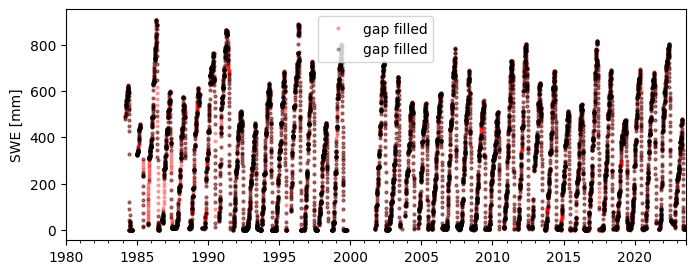

In [20]:
plt.figure(figsize=(8,3))
SWE_obs_basin_interp_df.iloc[:,10].plot(color='r', marker='o', ms=2, label='gap filled', lw=0, alpha=.3)
SWE_testbasin_df.iloc[:,10].plot(color='k', marker='o', ms=2, label='gap filled', lw=0, alpha=.3)
plt.xlabel('')
plt.ylabel('SWE [mm]')
plt.legend();

In [21]:
# Save flags for linear interpolation to a new Pandas dataframe (observations = 0; estimates = 1)
flags_interp_testbasin_da = SWE_testbasin_interp_da.copy().fillna(-999)
original_da = SWE_stations_ds.snw.copy().fillna(-999)
flags_interp_testbasin_da = xr.where(flags_interp_testbasin_da==original_da, 0, 1)

# Only drop columns that exist in the DataFrame
cols_to_drop = [col for col in ['lon', 'lat', 'station_name'] if col in flags_interp_testbasin_da.to_dataframe().columns]
flags_interp_testbasin_df = flags_interp_testbasin_da.to_dataframe().drop(columns=cols_to_drop).unstack()['snw'].T
flags_interp_testbasin_df['date'] =  flags_interp_testbasin_df.index.normalize()
flags_interp_testbasin_df = flags_interp_testbasin_df.set_index('date')
display(SWE_testbasin_interp_da)

<xarray.DataArray 'snw' (station_id: 78, time: 15918)> Size: 10MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * station_id  (station_id) object 624B 'ALE-05BA801' ... 'UU-MC-VVFrst'
  * time        (time) datetime64[ns] 127kB 1980-01-01 1980-01-02 ... 2023-07-31

In [22]:
# Merge test basin SWE and casr_df
SWE_testbasin_interp_df = SWE_obs_basin_interp_df.merge(casr_df, left_index=True, right_index=True, how='outer', suffixes=('_testbasin', '_casr'))

display(SWE_testbasin_interp_df)

,ALE-05BA801,ALE-05BA802,ALE-05BA806,ALE-05BA808,ALE-05BA810,ALE-05BA811,ALE-05BA812,ALE-05BA813,ALE-05BA814,ALE-05BB803,...,SWE_248,SWE_249,SWE_250,SWE_251,SWE_252,SWE_253,SWE_254,SWE_255,SWE_256,SWE_257
date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,32.062500,28.3125,37.000000,35.8125,30.625000,5.250000,5.437500,3.562500,3.8125,6.687500
1980-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,371.0,...,34.000000,32.7500,39.250000,40.1250,34.937500,6.187500,6.375000,4.375000,4.5000,7.250000
1980-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,36.687500,35.4375,41.937500,43.1250,37.687500,6.625000,7.125000,4.687500,4.7500,7.562500
1980-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,38.312500,37.0625,43.500000,44.4375,39.250000,7.937500,8.375000,6.062500,6.6250,9.125000
1980-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,39.437500,37.8125,44.750000,44.8750,39.812500,7.187500,7.750000,5.312500,5.7500,8.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.125000,0.0000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
2023-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.128906,0.0000,0.000977,0.1250,0.000244,0.000488,0.000244,0.000244,0.0000,0.000488
2023-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.125000,0.0000,0.125000,0.1250,0.000000,0.000488,0.000000,0.000000,0.0000,0.000000


In [23]:
start_date = pd.to_datetime("1980-01-01")
end_date = pd.to_datetime("2023-07-31")
chunk_years = 5

# Initialize output dataframes
all_SWE_obs = []
all_flags = []
all_donors = []

current_start = start_date

while current_start < end_date:
    current_end = min(current_start + pd.DateOffset(years=chunk_years), end_date)
    
    print(f"Processing chunk: {current_start.date()} to {current_end.date()}")

    chunk_df = SWE_testbasin_interp_df.loc[current_start:current_end].copy()
    
    SWE_obs_chunk, flags_chunk, donors_chunk = qm_gap_filling(
        chunk_df,
        window_days=window_days_default,
        min_obs_corr=min_obs_corr_default,
        min_obs_cdf=min_obs_cdf_default,
        min_corr=min_corr_default
    )

    all_SWE_obs.append(SWE_obs_chunk)
    all_flags.append(flags_chunk)
    all_donors.append(donors_chunk)

    current_start = current_end + pd.DateOffset(days=1)

# Combine the parts
SWE_obs_basin_gapfilled_df = pd.concat(all_SWE_obs)
flags_gapfill_basin_df = pd.concat(all_flags)
donor_stations_gapfill_basin_df = pd.concat(all_donors)

Processing chunk: 1980-01-01 to 1985-01-01
Calculating correlations...
Processing 1828 dates with missing data...
Pre-computing target data windows...
Processing batch 1/2
Processing batch 2/2
Gap filling completed. Filled 1971 missing values.
Processing chunk: 1985-01-02 to 1990-01-02
Calculating correlations...
Processing 1827 dates with missing data...
Pre-computing target data windows...
Processing batch 1/2
Processing batch 2/2
Gap filling completed. Filled 2182 missing values.
Processing chunk: 1990-01-03 to 1995-01-03
Calculating correlations...
Processing 1827 dates with missing data...
Pre-computing target data windows...
Processing batch 1/2
Processing batch 2/2
Gap filling completed. Filled 1020 missing values.
Processing chunk: 1995-01-04 to 2000-01-04
Calculating correlations...
Processing 1827 dates with missing data...
Pre-computing target data windows...
Processing batch 1/2
Processing batch 2/2
Gap filling completed. Filled 1716 missing values.
Processing chunk: 2000-0

In [24]:
# Combine linear interpolation and quantile mapping flags into a single Pandas dataframe
# if not flags_interp_basin_df.index.equals(flags_gapfill_basin_df.index) or not flags_interp_basin_df.columns.equals(flags_gapfill_basin_df.columns):
flags_basin_df = SWE_obs_basin_interp_df + flags_gapfill_basin_df

display(flags_basin_df)

,ALE-05BA801,ALE-05BA802,ALE-05BA806,ALE-05BA808,ALE-05BA810,ALE-05BA811,ALE-05BA812,ALE-05BA813,ALE-05BA814,ALE-05BB803,...,UU-MC-FisRdgTp,UU-MC-FisS,UU-MC-FisSFFrst,UU-MC-FisUpS,UU-MC-Hay,UU-MC-LvlFrst,UU-MC-UpFrst,UU-MC-UppClr,UU-MC-VVClr,UU-MC-VVFrst
date,,,,,,,,,,,,,,,,,,,,,
1980-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,371.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Combine gap filled dataset and metadata into a single dataset
SWE_P_gapfill_testbasin_da = xr.DataArray(data=SWE_obs_basin_gapfilled_df.values, coords=dict(time=SWE_obs_basin_gapfilled_df.index.values, station_id=SWE_obs_basin_gapfilled_df.columns.values), dims=['time','station_id'], name='SWE', attrs={'long_name':'Surface snow water equivalent','units':'kg m**-2'})
flags_testbasin_da = xr.DataArray(data=flags_basin_df.values, coords=dict(time=flags_basin_df.index.values, station_id=flags_basin_df.columns.values), dims=['time','station_id'], name='flag', attrs={'description':'observations = 0; estimates = 1'})
donor_stations_gapfill_testbasin_da = xr.DataArray(data=donor_stations_gapfill_basin_df.values, coords=dict(time=donor_stations_gapfill_basin_df.index.values, station_id=donor_stations_gapfill_basin_df.columns.values), dims=['time','station_id'], name='donor_stations', attrs={'description':'station_id of donor stations used for gap filling'})
SWE_testbasin_gapfilled_ds = xr.merge([SWE_P_gapfill_testbasin_da, flags_testbasin_da, donor_stations_gapfill_testbasin_da])

# Only assign coordinates for station_ids present in SWE_stations_ds
station_ids_all = SWE_obs_basin_gapfilled_df.columns.values
station_ids_in_ds = [sid for sid in station_ids_all if sid in SWE_stations_ds.station_id.values]
station_ids_not_in_ds = [sid for sid in station_ids_all if sid not in SWE_stations_ds.station_id.values]

# Prepare arrays for lat, lon, and station_name, filling with NaN or empty string for missing stations
lats = []
lons = []
names = []
for sid in station_ids_all:
	if sid in SWE_stations_ds.station_id.values:
		lat_val = SWE_stations_ds.sel(station_id=sid).lat.values
		lon_val = SWE_stations_ds.sel(station_id=sid).lon.values
		name_val = SWE_stations_ds.sel(station_id=sid).station_name.values
		# If returned value is an array, get the first element
		if isinstance(lat_val, np.ndarray):
			lat_val = lat_val.item() if lat_val.size == 1 else lat_val[0]
		if isinstance(lon_val, np.ndarray):
			lon_val = lon_val.item() if lon_val.size == 1 else lon_val[0]
		if isinstance(name_val, np.ndarray):
			name_val = name_val.item() if name_val.size == 1 else name_val[0]
		lats.append(float(lat_val))
		lons.append(float(lon_val))
		names.append(str(name_val))
	else:
		lats.append(np.nan)
		lons.append(np.nan)
		names.append("")

SWE_testbasin_gapfilled_ds = SWE_testbasin_gapfilled_ds.assign_coords({'lat':('station_id',lats),'lon':('station_id',lons),'station_name':('station_id',names)})

display(SWE_testbasin_gapfilled_ds)
display(flags_testbasin_da)

<xarray.Dataset> Size: 128MB
Dimensions:         (time: 15918, station_id: 335)
Coordinates:
  * time            (time) datetime64[ns] 127kB 1980-01-01 ... 2023-07-31
  * station_id      (station_id) object 3kB 'ALE-05BA801' ... 'UU-MC-VVFrst'
    lat             (station_id) float64 3kB 51.42 51.44 51.42 ... nan nan nan
    lon             (station_id) float64 3kB -116.2 -116.2 -116.2 ... nan nan
    station_name    (station_id) <U32 43kB 'BOW RIVER' 'PIPESTONE UPPER' ... ''
Data variables:
    SWE             (time, station_id) float64 43MB nan nan nan ... nan nan nan
    flag            (time, station_id) float64 43MB nan nan nan ... nan nan nan
    donor_stations  (time, station_id) object 43MB '' '' '' '' ... '' '' '' ''
Attributes:
    long_name:  Surface snow water equivalent
    units:      kg m**-2

<xarray.DataArray 'flag' (time: 15918, station_id: 335)> Size: 43MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * time        (time) datetime64[ns] 127kB 1980-01-01 1980-01-02 ... 2023-07-31
  * station_id  (station_id) object 3kB 'ALE-05BA801' ... 'UU-MC-VVFrst'
Attributes:
    description:  observations = 0; estimates = 1

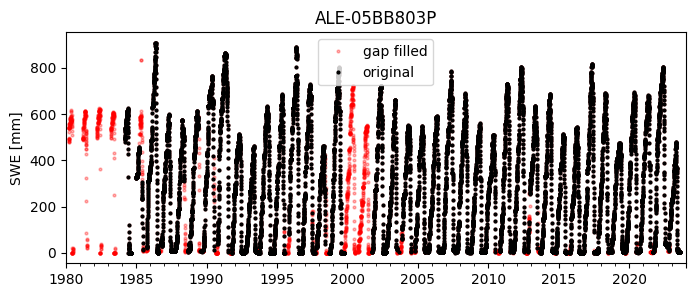

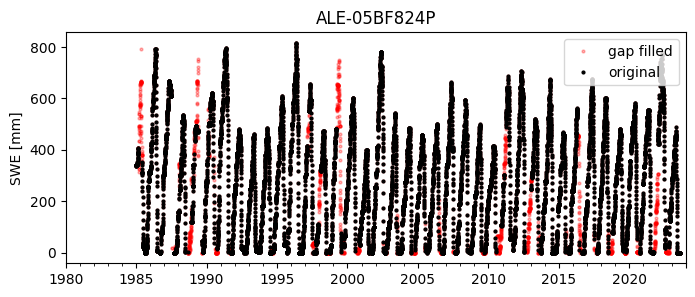

In [26]:
# Plot the first SWE station in the dataset to visually check gap filling results
plt.figure(figsize=(8,3))
SWE_obs_basin_gapfilled_df.iloc[:,10].plot(color='r', marker='o', ms=2, label='gap filled', lw=0, alpha=.3)
SWE_testbasin_interp_df.iloc[:,10].plot(color='k', marker='o', ms=2, label='original', lw=0)
plt.title(SWE_testbasin_interp_df.iloc[:,10].name)
plt.xlabel('')
plt.ylabel('SWE [mm]')
plt.legend();

plt.figure(figsize=(8,3))
SWE_obs_basin_gapfilled_df.iloc[:,15].plot(color='r', marker='o', ms=2, label='gap filled', lw=0, alpha=.3)
SWE_testbasin_interp_df.iloc[:,15].plot(color='k', marker='o', ms=2, label='original', lw=0)
plt.title(SWE_testbasin_interp_df.iloc[:,15].name)
plt.xlabel('')
plt.ylabel('SWE [mm]')
plt.legend();

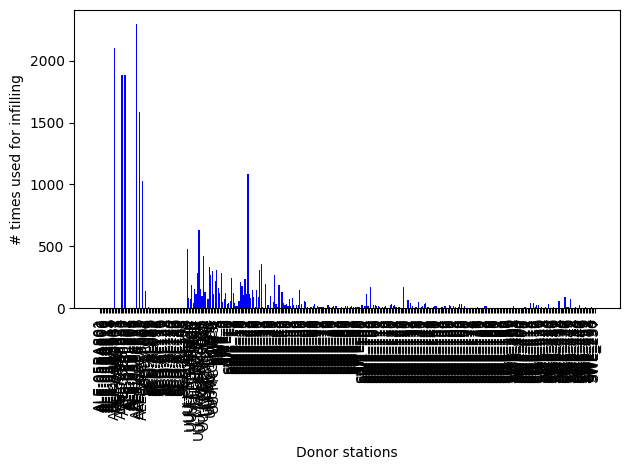

In [27]:
# Plot a bar chart of the number of times each donor station was used for infilling
count = []

for s in SWE_testbasin_interp_df.columns.values:
    count_s = SWE_testbasin_gapfilled_ds.donor_stations.where(SWE_testbasin_gapfilled_ds.donor_stations==s).count().data
    count.append(count_s)

fig = plt.figure()
plt.bar(SWE_testbasin_interp_df.columns.values, count, color='b')
plt.xticks(rotation=90)
plt.xlabel('Donor stations')
plt.ylabel('# times used for infilling')
plt.tight_layout();

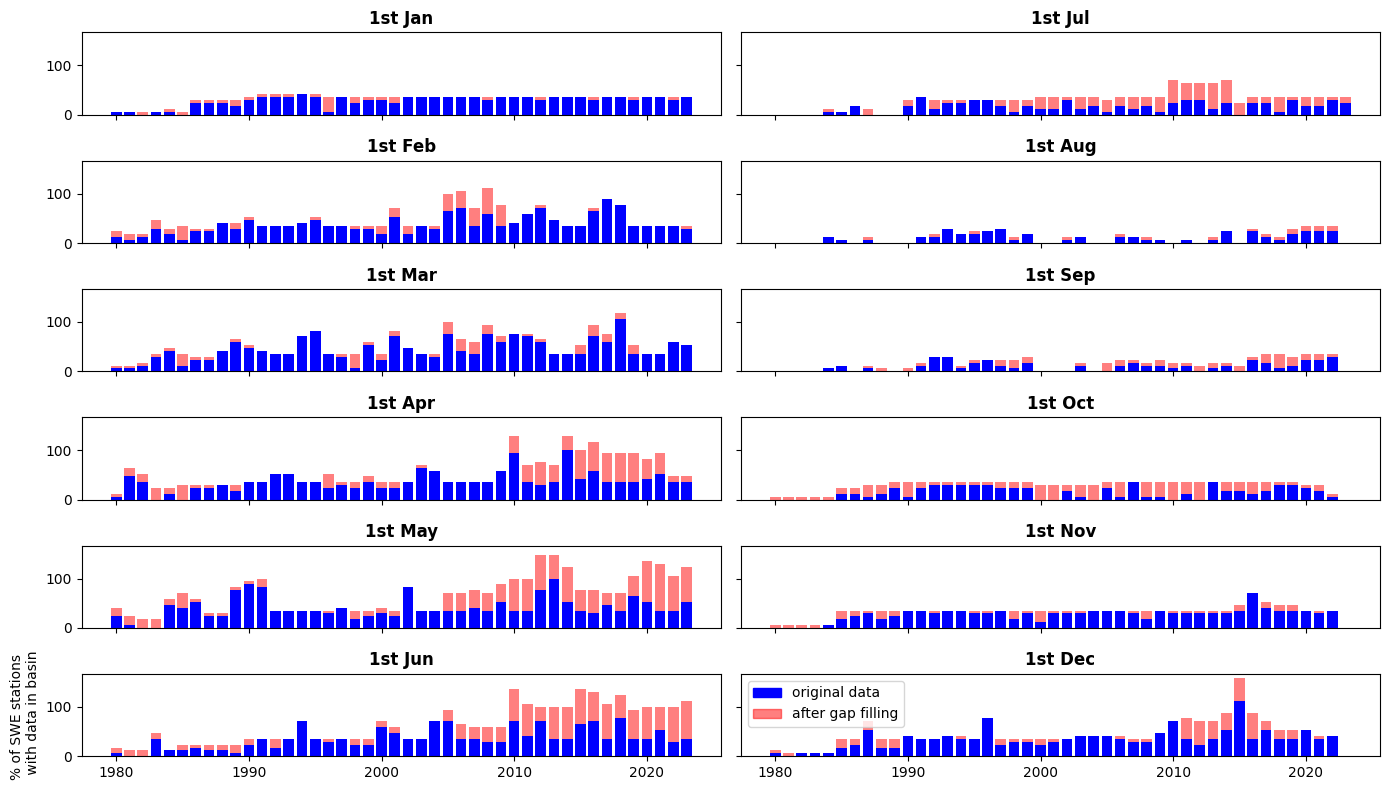

In [28]:
# Plot timeseries of the % of SWE stations with data in the test basin on the first day of each month, for the original data & after gap filling (flag=1)
fig = data_availability_monthly_plots_1(SWE_stations_ds, SWE_stations_ds.snw, SWE_testbasin_gapfilled_ds.SWE, flag=1)

In [ ]:
evaluation_dict = artificial_gap_filling(
    SWE_testbasin_interp_df,
    iterations=iterations_default,
    artificial_gap_perc=artificial_gap_perc_default,
    window_days=window_days_default,
    min_obs_corr=min_obs_corr_default,
    min_obs_cdf=min_obs_cdf_default,
    min_corr=min_corr_default,
    min_obs_KGE=min_obs_KGE_default,
    flag=1  # Set to 0 if you don't need plots
)

print("Artificial gap filling evaluation completed!")

Using 16 parallel jobs for gap filling evaluation
Parameters: iterations=2, gap_perc=100%
Starting optimized artificial gap filling...
Pre-computing data structures...
Calculating correlations...
Calculating correlations for 366 unique DOYs...
Pre-computing window masks...
Using parallel processing with 20 cores for correlation calculation...


Parallel Correlation Calc: 100%|███████████| 366/366 [05:48<00:00,  1.05DOYs/s, DOY=366, Workers=20]


Correlation calculation completed for 366 DOYs
Using 16 parallel jobs for 2 iterations
Processing 8040 combinations in parallel...


Parallel Processing:   6%| | 449/8040 [13:11<3:43:09,  1.76s/combinations, Workers=16, Completed=449


KeyboardInterrupt: 

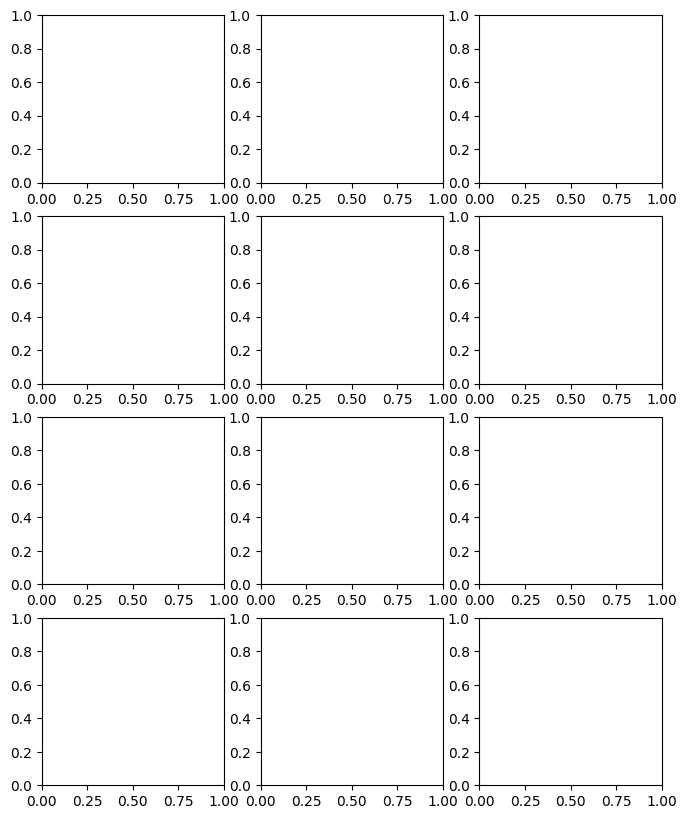

In [30]:
# Use optimized parallel processing for artificial gap filling
import multiprocessing as mp
from snowdroughtindex.core.gap_filling_notebook_optimized import artificial_gap_filling_optimized

# Set default values if not already defined
if 'iterations_default' not in locals():
    iterations_default = 1
if 'artificial_gap_perc_default' not in locals():
    artificial_gap_perc_default = 100
if 'window_days_default' not in locals():
    window_days_default = 7
if 'min_obs_corr_default' not in locals():
    min_obs_corr_default = 3
if 'min_obs_cdf_default' not in locals():
    min_obs_cdf_default = 10
if 'min_corr_default' not in locals():
    min_corr_default = 0.6
if 'min_obs_KGE_default' not in locals():
    min_obs_KGE_default = 3

# Determine optimal number of parallel jobs
n_jobs = min(mp.cpu_count(), iterations_default) if iterations_default > 1 else 1
n_jobs = 16
iterations_default = 2
print(f"Using {n_jobs} parallel jobs for gap filling evaluation")
print(f"Parameters: iterations={iterations_default}, gap_perc={artificial_gap_perc_default}%")

evaluation_dict = artificial_gap_filling_optimized(
    SWE_testbasin_interp_df,
    iterations=iterations_default,
    artificial_gap_perc=artificial_gap_perc_default,
    window_days=window_days_default,
    min_obs_corr=min_obs_corr_default,
    min_obs_cdf=min_obs_cdf_default,
    min_corr=min_corr_default,
    min_obs_KGE=min_obs_KGE_default,
    flag=1,  # Set to 0 if you don't need plots
    n_jobs=n_jobs  # Enable parallel processing
)

print("Optimized artificial gap filling evaluation completed!")

## 6. Summary

In this notebook, we've demonstrated the data preparation workflow for the Snow Drought Index package. We've loaded data, preprocessed it, extracted stations within the basin of interest, assessed data availability, and saved the processed data for use in subsequent analyses.

The workflow uses the following key functions from the `data_preparation` module:
- `load_swe_data()`, `load_precip_data()`, `load_basin_data()` for data loading
- `preprocess_swe()`, `preprocess_precip()` for data preprocessing
- `convert_to_geodataframe()` for converting data to GeoDataFrame
- `extract_stations_in_basin()` for extracting stations within a basin
- `filter_stations()` for filtering data by station
- `assess_data_availability()` for assessing data availability

These functions provide a standardized and reusable way to prepare data for the Snow Drought Index calculations.